<a href="https://colab.research.google.com/github/chumpblocckami/colabs/blob/main/MagicSimilaritySearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install imgbeddings
!pip install faiss

!sudo apt-get install libomp-dev

In [ ]:
import tqdm
import json
import tqdm
import requests
import pandas as pd

from PIL import Image
import requests
from io import BytesIO

from pprint import pprint

from imgbeddings import imgbeddings

In [ ]:
query_string = "https://api.scryfall.com/sets/2ec77b96d474--4891-a480-5d0b4e5c9372"
search_uri = json.loads(requests.get(query_string,params="fuzzy").text)["search_uri"]
card_data = pd.DataFrame()
data = json.loads(requests.get(search_uri,params="fuzzy").text)["data"]
pprint(data[0])

{'artist': 'Jason Felix',
 'artist_ids': ['af42a44c-8ec3-47a7-9047-5d29ddad186d'],
 'booster': True,
 'border_color': 'black',
 'card_back_id': '0aeebaf5-8c7d-4636-9e82-8c27447861f7',
 'cardmarket_id': 366809,
 'cmc': 7.0,
 'collector_number': '1',
 'color_identity': [],
 'colors': [],
 'digital': False,
 'edhrec_rank': 993,
 'finishes': ['nonfoil', 'foil'],
 'flavor_text': '"The emergence of the Eldrazi isn\'t necessarily a bad thing, '
                "as long as you've already lived a fulfilling and complete "
                'life without regrets."\n'
                '—Javad Nasrin, Ondu relic hunter',
 'foil': True,
 'frame': '2015',
 'full_art': False,
 'games': ['paper', 'mtgo'],
 'highres_image': True,
 'id': '8cf632ef-70e3-46f2-af21-14ea7ef30237',
 'illustration_id': 'eb002acc-80bb-4a3c-bff1-854254aac9c1',
 'image_status': 'highres_scan',
 'image_uris': {'art_crop': 'https://c1.scryfall.com/file/scryfall-cards/art_crop/front/8/c/8cf632ef-70e3-46f2-af21-14ea7ef30237.jpg?1612809

In [ ]:
def encode(p):
    return {
        "id": p["id"],
        "name": p["name"],
    }
df_mtg = [encode(p) for p in data]
pd.DataFrame(df_mtg).head()

,id,name
0,8cf632ef-70e3-46f2-af21-14ea7ef30237,All Is Dust
1,03648eff-8652-4750-a3d2-3338ce9e5a81,Artisan of Kozilek
2,c3909816-5cc2-4712-bc7d-534ae0b9229c,Eldrazi Conscription
3,0e0d989d-7186-40dc-bdfe-cfbb77656bc8,"Emrakul, the Aeons Torn"
4,69714257-2848-48e1-95cf-cdb6595215f0,Karn Liberated


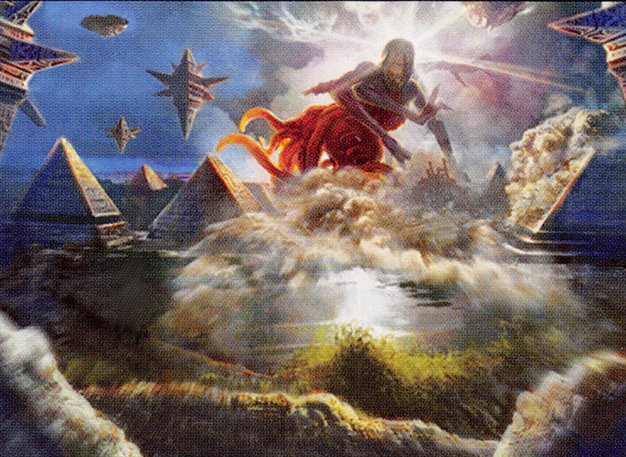

In [ ]:
imgs = [Image.open(BytesIO(requests.get(doc["image_uris"]["art_crop"]).content))  for doc in data]

In [ ]:
ibed = imgbeddings()
embeddings = ibed.to_embeddings(imgs)
embeddings.shape

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


  0%|          | 0/175 [00:00<?, ?it/s]

(175, 768)

In [ ]:
ibed.pca_fit(embeddings, 128)

embeddings_pca = ibed.pca_transform(embeddings)
embeddings_pca.shape

(175, 128)

In [ ]:
import faiss

from sklearn.preprocessing import normalize

from IPython.display import HTML
from io import BytesIO
import base64
import numpy as np

import matplotlib.pyplot as plt 

In [ ]:
index = faiss.index_factory(embeddings_pca.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)

index.add(normalize(embeddings_pca))
index.ntotal

175

[[ 25  11   9 104  50  15  78 139 153 117  43]]
[[0.99999994 0.4231451  0.3770458  0.32738492 0.31128103 0.30879763
  0.28775463 0.27689537 0.2652373  0.25582665 0.2404389 ]]


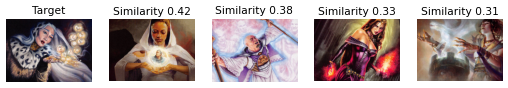

In [ ]:
search_id = 25

# faiss results are zero-indexed, so must -1 when searching, +1 after retrieving
q_embedding = np.expand_dims(embeddings_pca[search_id - 1, :], 0)

# the search will return the query itself, so search for +1 result
distances, indices = index.search(normalize(q_embedding), 10 + 1)
print(indices + 1)
print(distances)

imgs_to_display = 5

fig, axs = plt.subplots(1,imgs_to_display,figsize=(10,8),dpi=64)
n = 0
for idx, dist in zip(indices[0][:imgs_to_display],distances[0][:imgs_to_display]):
  axs[n].imshow(imgs[idx])
  title = "Similarity "+str(round(dist,2)) if n != 0 else "Target"
  axs[n].set_title(title)
  axs[n].axis("off")
  n = n+1

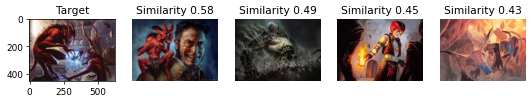

In [ ]:
url = "https://c1.scryfall.com/file/scryfall-cards/art_crop/front/4/a/4abf9b03-4157-42f0-ab3d-484bd9b64bb2.jpg?1625193603"
target_image = Image.open(BytesIO(requests.get(url).content))
target_image.save("./charmbreaker_devils.png")

img_path = "./charmbreaker_devils.png"
img_embedding = ibed.to_embeddings(img_path)
distances, indices = index.search(normalize(img_embedding), 10)

imgs_to_display = 5

fig, axs = plt.subplots(1,imgs_to_display,figsize=(10,8),dpi=64)
axs[0].imshow(target_image)
axs[0].set_title("Target")

n = 1
for idx, dist in zip(indices[0][:imgs_to_display-1],distances[0][:imgs_to_display-1]):
  axs[n].imshow(imgs[idx])
  title = "Similarity "+str(round(dist,2)) if n != 0 else "Target"
  axs[n].set_title(title)
  axs[n].axis("off")
  n = n+1